In [2]:
import copy
from datetime import datetime
from joblib import Parallel, delayed
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import numpy as np
import pandas as pd
import random
from scipy.signal import resample
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [4]:
%load_ext memory_profiler

In [5]:
from truth import IeeeGroundTruth
from wavelet import apply_wavelet
from peaks import get_peaks_v2
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale,
    bandpass,
    get_hr,
    get_hrv
)

In [6]:
class LossFactory:

    def __init__(self, split_size, loss_type = 'mse', gamma = 1.0, mse_weight = None, dtw_weight = None):
        
        if loss_type not in ['mse', 'dtw', 'combined']:
            raise ValueError(f'Loss type [{loss_type}] not supported')
        
        self.split_size = split_size
        self.gamma = gamma
        self.mse_weight = mse_weight
        self.dtw_weight = dtw_weight

        if loss_type == 'mse':
            self.loss_function = self.mse_loss
        elif loss_type == 'dtw':
            self.loss_function = self.soft_dtw_loss
        elif loss_type == 'combined':
            self.loss_function = self.combined_loss
        
    def __call__(self, y_pred, data):
        return self.loss_function(y_pred, data)

    def get_func(self):
        return self.loss_function

    def mse_loss(self, y_pred, data):
        
        y_true = data.get_label()
        num_batches = int(len(y_pred) / self.split_size)
        errs = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * self.split_size: (i + 1) * self.split_size]
            y_pred_curr = y_pred[i * self.split_size: (i + 1) * self.split_size]
            
            err = y_true_curr - y_pred_curr
            errs[i * self.split_size: (i + 1) * self.split_size] = err

        grad = -2 * errs
        hess = 2 * np.ones_like(y_true)
        return grad, hess

    # def soft_dtw_loss(self, y_pred, data):

    #     y_true = data.get_label()
    #     num_batches = int(len(y_pred) / self.split_size)
    #     grads = np.zeros_like(y_true)
    #     hesses = np.zeros_like(y_true)

    #     for i in range(num_batches):

    #         y_true_curr = y_true[i * self.split_size: (i + 1) * self.split_size]
    #         y_pred_curr = y_pred[i * self.split_size: (i + 1) * self.split_size]
            
    #         grad_curr, hess_curr = self.soft_dtw_loss_helper(y_true_curr, y_pred_curr)
    #         grad_curr = grad_curr.flatten()
    #         hess_curr = hess_curr.flatten()

    #         grads[i * self.split_size: (i + 1) * self.split_size] = grad_curr
    #         hesses[i * self.split_size: (i + 1) * self.split_size] = hess_curr

    #     return grads, hesses
    def soft_dtw_loss(self, y_pred, data):

        def batch_loss_helper(i, y_true, y_pred, split_size):
            
            y_true_curr = y_true[i * split_size: (i + 1) * split_size]
            y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]

            grad_curr, hess_curr = self.soft_dtw_loss_helper(y_true_curr, y_pred_curr)
            grad_curr = grad_curr.flatten()
            hess_curr = hess_curr.flatten()

            return grad_curr, hess_curr

        y_true = data.get_label()
        num_batches = int(len(y_pred) / self.split_size)
        grads = np.zeros_like(y_true)
        hesses = np.zeros_like(y_true)

        results = Parallel(n_jobs = -1)(
            delayed(batch_loss_helper)(
                i, y_true, y_pred, self.split_size
            ) for i in range(num_batches)
        )

        for i, (grad_curr, hess_curr) in enumerate(results):
            grads[i * self.split_size: (i + 1) * self.split_size] = grad_curr
            hesses[i * self.split_size: (i + 1) * self.split_size] = hess_curr

        return grads, hesses
    
    def soft_dtw_loss_helper(self, y_true, y_pred):
        x = y_true.reshape(-1, 1)
        y = y_pred.reshape(-1, 1)
        D = SquaredEuclidean(x, y)
        sdtw = SoftDTW(D, gamma = self.gamma)
        sdtw.compute()
        E = sdtw.grad()
        G = D.jacobian_product(E)
        return G, np.ones(len(G))
    
    def combined_loss(self, y_pred, data):

        if self.mse_weight is None or self.dtw_weight is None:
            raise ValueError('mse_weight and dtw_weight must be set before calling combined_loss')

        mse_grads, mse_hesses = self.mse_loss(y_pred, data)
        dtw_grads, dtw_hesses = self.soft_dtw_loss(y_pred, data)

        combined_grad = self.mse_weight * mse_grads + self.dtw_weight * dtw_grads
        combined_hess = self.mse_weight * mse_hesses + self.dtw_weight * dtw_hesses

        return combined_grad, combined_hess

In [17]:
import scipy
def ppg_to_bvp(ppg_signal, sampling_rate, cutoff_frequency=0.1):
    """
    Convert a PPG (Photoplethysmogram) signal to a BVP (Blood Volume Pulse) signal using a highpass filter.

    Parameters:
    ppg_signal (array-like): Input PPG signal
    sampling_rate (float): Sampling rate of the PPG signal in Hz
    cutoff_frequency (float, optional): Cutoff frequency for the highpass filter in Hz (default: 0.1 Hz)

    Returns:
    bvp_signal (np.array): Output BVP signal
    """

    # Create a highpass Butterworth filter
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff_frequency = cutoff_frequency / nyquist_frequency
    b, a = scipy.signal.butter(N=1, Wn=normalized_cutoff_frequency, btype='high', analog=False)

    # Apply the highpass filter to the PPG signal
    bvp_signal = scipy.signal.lfilter(b, a, ppg_signal)

    return min_max_scale(bvp_signal)

In [21]:
import xgboost as xgb
class LonePineGBM:
    
    def __init__(self, truths, label_col = 'bvp', subject_col = 'subject',
                # model customization
                model_type = 'gbdt', random_state = None, loss_type = 'mse', excluded_subject = None,
                # hyperparameters
                n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3, early_stopping_rounds = 50,
                mse_weight = None, dtw_weight = None, data_beg = 1000, data_end = 10000, batches = 1, finetune = True,
                min_bandpass_freq = 0.67, max_bandpass_freq = 3.0, bandpass_order = 4,
                predicted_peaks_prominence = 0.22, true_peaks_prominence = 0.15,
                # hyperparams from LightGBM docs
                max_depth = 7, num_leaves = 75, max_bin = 255,
                num_feats_per_channel = 3, skip_amount = 15):
        
        if model_type not in ['gbdt', 'rf']:
            raise ValueError(f'Model type [{model_type}] not supported')
        
        self.label_col = label_col
        self.subject_col = subject_col

        self.model_type = model_type
        self.random_state = random_state
        self.excluded_subject = excluded_subject

        self.n_estimators = n_estimators
        self.split_size = split_size
        self.learning_rate = learning_rate
        self.test_size = test_size
        self.early_stopping_rounds = early_stopping_rounds

        self.data_beg = data_beg
        self.data_end = data_end
        self.finetune = finetune

        self.min_bandpass_freq = min_bandpass_freq
        self.max_bandpass_freq = max_bandpass_freq
        self.bandpass_order = bandpass_order
        self.predicted_peaks_prominence = predicted_peaks_prominence
        self.true_peaks_prominence = true_peaks_prominence

        self.max_depth = max_depth
        self.num_leaves = num_leaves
        self.max_bin = max_bin

        self.num_feats_per_channel = num_feats_per_channel
        self.skip_amount = skip_amount

        self.gbm = None
        self.training_loss = None
        self.test_loss = None

        self.given_data = self.prepare_dataset_from_subjects(truths, data_beg = data_beg, data_end = data_end)
        self.features = list(self.given_data.drop(columns = [self.label_col, self.subject_col]).columns)
        if self.excluded_subject is not None:
            self.given_data = self.given_data[self.given_data[self.subject_col] != self.excluded_subject]

        if self.random_state is not None:
            random.seed(self.random_state)
        splits = self.split_data()
        self.train_split_indices = random.sample(range(len(splits)), int(len(splits) * (1 - self.test_size)))
        self.train_splits = [splits[i] for i in self.train_split_indices]
        self.test_splits = [splits[i] for i in range(len(splits)) if i not in self.train_split_indices]
        
        self.train_data = []
        self.train_data_just_data = []
        batch_size = len(self.train_splits) // batches
        print(f'Rows per batch: {batch_size * self.split_size}')
        for batch_num in range(batches):
            batch_split_idxs = random.sample(range(len(self.train_splits)), batch_size)
            batch_splits = [self.train_splits[i] for i in batch_split_idxs]
            self.train_splits = [self.train_splits[i] for i in range(len(self.train_splits)) if i not in batch_split_idxs]

            train_indices = [idx for split in batch_splits for idx in split]
            training_rows = self.given_data.iloc[train_indices].drop(columns = [self.subject_col])
            train_X = training_rows.drop(columns = [self.label_col]).to_numpy()
            train_y = training_rows[self.label_col].to_numpy()

            # batch_data = lgb.Dataset(train_X, train_y, free_raw_data = False)
            batch_data = xgb.DMatrix(train_X, train_y)
            self.train_data.append(batch_data)
            self.train_data_just_data.append(train_X)

        test_indices = [idx for split in self.test_splits for idx in split]
        test_rows = self.given_data.iloc[test_indices].drop(columns = [self.subject_col])
        test_X = test_rows.drop(columns = [self.label_col]).to_numpy()
        test_y = test_rows[self.label_col].to_numpy()
        # self.test_data = lgb.Dataset(test_X, test_y, free_raw_data = False)
        self.test_data = xgb.DMatrix(test_X, test_y)
        self.test_X = test_X
        self.test_y = test_y

        self.loss = LossFactory(self.split_size, loss_type = loss_type, mse_weight = mse_weight, dtw_weight = dtw_weight)
    
    def split_data(self, to_exclude = None):
        
        data_in_use = self.given_data if to_exclude is None else self.given_data[~self.given_data[self.subject_col].isin(to_exclude)]

        subject_indices = data_in_use.groupby(self.subject_col).indices
        splits = []
        for _, indices in subject_indices.items():
            
            n_splits = len(indices) // self.split_size
            if n_splits > 0:

                subject_splits = []
                for i in range(n_splits):
                    split_start = i * self.split_size
                    split_end = (i + 1) * self.split_size
                    subject_split = indices[split_start: split_end]
                    subject_splits.append(subject_split)
                
                splits.extend(subject_splits)
        
        return splits

    def fit(self):
        t1 = datetime.today()
        
        self.params = {
            'metric': 'None',
            'verbosity': -1,
            'learning_rate': self.learning_rate,
            'objective': 'regression',
            'boosting': self.model_type,
            'max_depth': self.max_depth,
            'num_leaves': self.num_leaves,
            'max_bin': self.max_bin,
        }
    
        if self.model_type == 'rf':
            self.params['bagging_freq'] = 1
            self.params['bagging_fraction'] = 0.8


        training_loss_key = 'hr_err'
        feval = self.hr_error_eval_metric
        print('loss is loss')
        
        training_meta = {}

        for train_data in self.train_data:
            
            if self.model_type == 'gbdt':
                self.gbm = lgb.train(
                    self.params,
                    train_data,
                    valid_sets = [train_data, self.test_data],
                    valid_names=['train', 'test'],
                    fobj = self.loss,
                    num_boost_round = self.n_estimators,
                    feval=feval,
                    callbacks=[
                        early_stopping(stopping_rounds = self.early_stopping_rounds),
                        log_evaluation(period=5)
                    ],
                    evals_result = training_meta,
                    init_model = self.gbm
                )
            else:
                self.gbm = lgb.train(
                    self.params,
                    train_data,
                    valid_sets = [train_data, self.test_data],
                    valid_names=['train', 'test'],
                    num_boost_round = self.n_estimators,
                    feval=feval,
                    callbacks=[
                        early_stopping(stopping_rounds = self.early_stopping_rounds),
                        log_evaluation(period=5)
                    ],
                    evals_result = training_meta,
                )

            mse, hr_err, hr_err_sq = self.eval()
            print(f'Before fine-tuning: MSE = {mse}, HR error = {hr_err}, HR error (squared) = {hr_err_sq}')

            if self.model_type == 'gbdt' and self.finetune:
                
                print('\n\nFine-tuning...')
                gbm_copy = copy.deepcopy(self.gbm)
                pred = gbm_copy.predict(train_data.get_data())
                
                # new_targ = train_data.get_label() - pred
                new_targ = np.ones(len(pred))
                nsplits = len(pred) // self.split_size
                labels = train_data.get_label()
                for i in range(nsplits):
                    pred_curr = pred[i * self.split_size: (i + 1) * self.split_size]
                    label_curr = labels[i * self.split_size: (i + 1) * self.split_size]
                    hr_err = self.get_hr_error(pred_curr, label_curr, square = True)
                    new_targ[i * self.split_size: (i + 1) * self.split_size] = hr_err
                
                new_train_data = lgb.Dataset(train_data.get_data(), label = new_targ)

                self.gbm = lgb.train(
                    self.params,
                    new_train_data,
                    valid_sets = [new_train_data, self.test_data],
                    valid_names=['train', 'test'],
                    fobj = self.loss,
                    num_boost_round = self.n_estimators // 2,
                    feval=feval,
                    callbacks=[
                        early_stopping(stopping_rounds = self.early_stopping_rounds // 2),
                        log_evaluation(period=5)
                    ],
                    evals_result = training_meta,
                    init_model = gbm_copy
                )

            

        self.training_loss = training_meta['train'][training_loss_key]
        self.test_loss = training_meta['test'][training_loss_key]
        print(f'Finished training in {datetime.today() - t1}')
    
    def fit_xgb(self):
        t1 = datetime.today()

        self.params = {
            'learning_rate': self.learning_rate,
            'booster': 'gbtree',
            'max_depth': self.max_depth,
            'num_leaves': self.num_leaves,
            'max_bin': self.max_bin,
        }

        feval = self.hr_error_eval_metric_xgb

        for train_data, train_data_just_data in zip(self.train_data, self.train_data_just_data):

            self.gbm = xgb.train(
                self.params,
                train_data,
                num_boost_round=self.n_estimators,
                early_stopping_rounds=self.early_stopping_rounds,
                feval=feval,
                verbose_eval=5,
                evals=[(train_data, 'train'), (self.test_data, 'test')],
                xgb_model=self.gbm,
                obj = self.loss.get_func()
            )

            # mse, hr_err, hr_err_sq = self.eval()
            # print(f'Before fine-tuning: MSE = {mse}, HR error = {hr_err}, HR error (squared) = {hr_err_sq}')

            if self.finetune:

                print('\n\nFine-tuning...')
                gbm_copy = self.gbm.copy()
                pred = gbm_copy.predict(train_data)

                new_targ = np.ones(len(pred))
                nsplits = len(pred) // self.split_size
                labels = train_data.get_label()
                for i in range(nsplits):
                    pred_curr = pred[i * self.split_size: (i + 1) * self.split_size]
                    label_curr = labels[i * self.split_size: (i + 1) * self.split_size]
                    new_targ[i * self.split_size: (i + 1) * self.split_size] = label_curr - pred_curr

                new_train_data = xgb.DMatrix(train_data_just_data, label=new_targ)

                self.gbm = xgb.train(
                    self.params,
                    new_train_data,
                    num_boost_round=self.n_estimators // 2,
                    early_stopping_rounds=self.early_stopping_rounds // 2,
                    feval=feval,
                    verbose_eval=5,
                    evals=[(new_train_data, 'train'), (self.test_data, 'test')],
                    xgb_model=gbm_copy,
                    obj = self.loss.get_func()
                )

        print(f'Finished training in {datetime.today() - t1}')

    def predict(self, X):
        return self.gbm.predict(X)
    
    def save(self, model_file = 'lonePineGBM.xgb'):

        # new_params = copy.deepcopy(self.params)
        # new_params['learning_rate'] = 0.0000001
        # new_gbm = lgb.train(self.params, self.train_data[0], num_boost_round=1, init_model = self.gbm)

        # # import onnxmltools
        # # from onnxconverter_common.data_types import FloatTensorType

        # # initial_types = [('input', FloatTensorType([None, new_gbm.num_feature()]))]
        # # onnx_model = onnxmltools.convert_lightgbm(new_gbm, initial_types=initial_types)
        # # onnxmltools.utils.save_model(onnx_model, model_file)

        # import onnxmltools
        # from onnxconverter_common.data_types import FloatTensorType
        # onnx_model = onnxmltools.convert_lightgbm(new_gbm, initial_types=[('input', FloatTensorType([None, new_gbm.num_feature()]))])

        # # Save as protobuf
        # onnxmltools.utils.save_model(onnx_model, model_file)

        self.gbm.save_model(model_file)

    
    def load_from_file(self, model_file):
        self.gbm = lgb.model_from_string(model_file)

    def eval(self):
        
        test_X = self.test_data.get_data()
        test_y = self.test_data.get_label()
        nsplits = int(len(test_X) / self.split_size)
        errs = []
        mses = np.zeros(len(test_X))
        
        for i in range(nsplits):

            curr_pred = self.predict(test_X[i * self.split_size: (i + 1) * self.split_size, :])
            curr_true = test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 5, use_bandpass = True)
            
            mses[i * self.split_size: (i + 1) * self.split_size] = curr_true - curr_pred
            hr_err = self.get_hr_error(curr_true, curr_pred, square = False)
            errs.append(hr_err)
        
        return np.mean(np.square(mses)), np.mean(errs), np.mean(np.square(errs))

    def xgb_eval(self):
        
        nsplits = int(len(self.test_X) / self.split_size)
        errs = []
        mses = np.zeros(len(self.test_X))
        
        for i in range(nsplits):

            curr_pred = self.predict(xgb.DMatrix(self.test_X[i * self.split_size: (i + 1) * self.split_size, :]))
            curr_true = self.test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 5, use_bandpass = True)
            
            mses[i * self.split_size: (i + 1) * self.split_size] = curr_true - curr_pred
            hr_err = self.get_hr_error(curr_true, curr_pred, square = False)
            errs.append(hr_err)
        
        return np.mean(np.square(mses)), np.mean(errs), np.mean(np.square(errs))
    
    def validate(self):

        test_X = self.test_data.get_data()
        test_y = self.test_data.get_label()
        nsplits = int(len(test_X) / self.split_size)
        
        errors = []
        for i in range(nsplits):

            curr_pred = self.predict(test_X[i * self.split_size: (i + 1) * self.split_size, :])
            curr_true = test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 5, use_bandpass = True)
            
            mse = np.mean(np.square(curr_true - curr_pred))
            hr_err = self.get_hr_error(curr_true, curr_pred, square = False)
            hrv_err = self.get_hrv_error(curr_true, curr_pred, square = False)
            peaks_err = self.get_peaks_error(curr_true, curr_pred, square = False)
            errors.append({
                'mse': mse,
                'hr_err': hr_err,
                'hrv_err': hrv_err,
                'peaks_err': peaks_err
            })

        return errors

    def xgb_validate(self):

        test_X = self.test_X
        test_y = self.test_y
        nsplits = int(len(test_X) / self.split_size)
        
        errors = []
        for i in range(nsplits):
            curr_X = xgb.DMatrix(test_X[i * self.split_size: (i + 1) * self.split_size, :])
            curr_pred = self.predict(curr_X)
            curr_true = test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 5, use_bandpass = True)
            
            mse = np.mean(np.square(curr_true - curr_pred))
            hr_err = self.get_hr_error(curr_true, curr_pred, square = False)
            hrv_err = self.get_hrv_error(curr_true, curr_pred, square = False)
            peaks_err = self.get_peaks_error(curr_true, curr_pred, square = False)
            errors.append({
                'mse': mse,
                'hr_err': hr_err,
                'hrv_err': hrv_err,
                'peaks_err': peaks_err
            })

        return errors

    def plot_loss(self):
        if self.training_loss is not None and self.test_loss is not None:
            training_loss_normed = min_max_scale(self.training_loss)
            test_loss_normed = min_max_scale(self.test_loss)
            plt.plot(training_loss_normed, label = 'training loss')
            plt.plot(test_loss_normed, label = 'test loss')
            plt.legend()
        
    def get_model_stats(self):

        model_info = self.gbm.dump_model()
        tree_depths = []

        for tree_info in model_info['tree_info']:
            tree_structure = tree_info['tree_structure']
            
            # Recursive function to compute the depth of a tree
            def calculate_depth(node, current_depth=0):
                if 'leaf_value' in node:
                    return current_depth
                else:
                    left_depth = calculate_depth(node['left_child'], current_depth + 1)
                    right_depth = calculate_depth(node['right_child'], current_depth + 1)
                    return max(left_depth, right_depth)

            tree_depth = calculate_depth(tree_structure)
            tree_depths.append(tree_depth)
        

        print(f'Best test loss: {min(self.test_loss)}\n')
        print('Tree depth stats:')
        print('Min tree depth:', min(tree_depths))
        print('Max tree depth:', max(tree_depths))
        print('Avg tree depth:', np.mean(tree_depths))
        print('\nFeature importances:')
        display(self.get_feature_importances())
    
    def get_feature_importances(self):
        importances = self.gbm.feature_importance(importance_type='gain')
        feature_importances = pd.DataFrame({'feature': self.features, 'importance': importances})
        feature_importances = feature_importances.sort_values('importance', ascending=False)
        return feature_importances
    
    def hr_error_eval_metric(self, y_pred, eval_data):
        y_true = eval_data.get_label()
        nsplits = int(len(y_pred) / self.split_size)
        hr_err = []
        for i in range(nsplits):
            curr_pred = y_pred[i * self.split_size: (i + 1) * self.split_size]
            curr_true = y_true[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 10, use_bandpass = True)
            hr_err.append(self.get_hr_error(curr_true, curr_pred, square = False))
        return 'hr_err', np.mean(hr_err), False
    
    def hr_error_eval_metric_xgb(self, y_pred, eval_data):
        y_true = eval_data.get_label()
        nsplits = int(len(y_pred) / self.split_size)
        hr_err = []
        for i in range(nsplits):
            curr_pred = y_pred[i * self.split_size: (i + 1) * self.split_size]
            curr_true = y_true[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 10, use_bandpass = True)
            hr_err.append(self.get_hr_error(curr_true, curr_pred, square = False))
        return 'hr_err', np.mean(hr_err)
    
    def get_hr_error(self, y_true, y_pred, square = True):

        true_peaks, _ = self.get_true_peaks(y_true)
        pred_peaks, _ = self.get_predicted_peaks(y_pred)

        if len(true_peaks) >= 2:
            true_ibis = np.diff(true_peaks) / 64
            true_hr = 60 / np.mean(true_ibis)
        else:
            true_hr = 0

        if len(pred_peaks) >= 2:
            pred_ibis = np.diff(pred_peaks) / 64
            pred_hr = 60 / np.mean(pred_ibis)
        else:
            pred_hr = 0
        
        if square:
            return np.power(true_hr - pred_hr, 2)
        return abs(true_hr - pred_hr)
    
    def get_peaks_error(self, y_true, y_pred, square = True):
        true_peaks, _ = self.get_true_peaks(y_true)
        pred_peaks, _ = self.get_predicted_peaks(y_pred)
        if square:
            return np.power(len(true_peaks) - len(pred_peaks), 2)
        return abs(len(true_peaks) - len(pred_peaks))
    
    def get_hrv_error(self, y_true, y_pred, square = True):

        true_peaks, _ = self.get_true_peaks(y_true)
        pred_peaks, _ = self.get_predicted_peaks(y_pred)

        if len(true_peaks) >= 2:
            true_ibis = np.diff(true_peaks) / 64
            true_hrv = get_hrv(true_ibis)
        else:
            true_hrv = 0

        if len(pred_peaks) >= 2:
            pred_ibis = np.diff(pred_peaks) / 64
            pred_hrv = get_hrv(pred_ibis)
        else:
            pred_hrv = 0
        
        if square:
            return np.power(true_hrv - pred_hrv, 2)
        return abs(true_hrv - pred_hrv)
    
    def process_signal(self, y_true, y_pred, smoothing_window = 10, use_bandpass = False):
    
        orig_len = len(y_pred)
        # y_pred = ppg_to_bvp(y_pred, 64)
        y_pred = n_moving_avg(y_pred, smoothing_window)
        y_pred = resample(y_pred, orig_len)
        if use_bandpass:
            y_pred = bandpass(y_pred, 64, [self.min_bandpass_freq, self.max_bandpass_freq], self.bandpass_order)
        y_pred = min_max_scale(y_pred)
        
        y_true = n_moving_avg(y_true, 20)
        y_true = resample(y_true, orig_len)
        if use_bandpass:
            y_true = bandpass(y_true, 64, [self.min_bandpass_freq, self.max_bandpass_freq], self.bandpass_order)
        y_true = min_max_scale(y_true)
        
        return y_true, y_pred
    
    def get_predicted_peaks(self, signal):
        return get_peaks_v2(signal, 64, 3.0, -1, prominence = self.predicted_peaks_prominence, with_min_dist = True, with_valleys = False)
    def get_true_peaks(self, signal):
        return get_peaks_v2(signal, 64, 3.0, -1, prominence = self.true_peaks_prominence, with_min_dist = True, with_valleys = False)

    def prepare_dataset_from_subjects(self, truths, data_beg = 1000, data_end = 2000):
        data_arr = []
        for i in range(len(truths)):    
            truth = truths[i]
            data = truth.prepare_data_for_ml(self.num_feats_per_channel, self.skip_amount)
            data = data.iloc[data_beg: data_end, :]
            data['subject'] = i + 1
            data_arr.append(data)
        return pd.concat(data_arr)


In [25]:
def subjectwise_kfold(truths, model_type = 'gbdt', random_state = None, loss_type = 'mse',
                    n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3, early_stopping_rounds = 50,
                    mse_weight = None, dtw_weight = None, data_beg = 1000, data_end = 10000, batches = 1, finetune = True, 
                    min_bandpass_freq = 0.67, max_bandpass_freq = 3.0, bandpass_order = 4,
                    predicted_peaks_prominence = 0.22, true_peaks_prominence = 0.15,
                    max_depth = 7, num_leaves = 75, max_bin = 255, num_feats_per_channel = 3, skip_amount = 15,
                    rounds_per_model = 1, collect = False):
        
        models = {}
        for subj_idx in range(len(truths)):
            models[subj_idx + 1] = []
            for i in range(rounds_per_model):
                
                print(f'\n\nTraining excluding subject {subj_idx + 1}...\n')
                mod = LonePineGBM(
                    truths = truths,
                    model_type = model_type,
                    random_state = random_state,
                    loss_type = loss_type,
                    n_estimators = n_estimators,
                    split_size = split_size,
                    learning_rate = learning_rate,
                    test_size = test_size,
                    early_stopping_rounds = early_stopping_rounds,
                    mse_weight = mse_weight,
                    dtw_weight = dtw_weight,
                    data_beg = data_beg,
                    data_end = data_end,
                    batches = batches,
                    finetune = finetune,
                    min_bandpass_freq = min_bandpass_freq,
                    max_bandpass_freq = max_bandpass_freq,
                    bandpass_order = bandpass_order,
                    predicted_peaks_prominence = predicted_peaks_prominence,
                    true_peaks_prominence = true_peaks_prominence,
                    max_depth = max_depth,
                    num_leaves = num_leaves,
                    max_bin = max_bin,
                    num_feats_per_channel = num_feats_per_channel,
                    skip_amount = skip_amount,
                    excluded_subject = subj_idx + 1
                )
                mod.fit_xgb()
                models[subj_idx + 1].append(mod)
        
        model_performances = {}
        for subj_idx in models:
            model_performances[subj_idx] = []
            for i in range(rounds_per_model):
                mod = models[subj_idx][i]
                
                if collect:
                    model_performances[subj_idx].append(mod.xgb_validate())
                else:
                    model_performances[subj_idx].append(mod.xgb_eval())

                
        if collect:
            return model_performances

        mean_hr_score = np.mean([model_performances[subj_idx][i][1] for subj_idx in model_performances for i in range(rounds_per_model)])
        return mean_hr_score, models, model_performances
    

class LonePineOptimizer:
    """
    Bayesian optimization class for hyperparameter tuning.
    """

    def __init__(self, truths):
        """
        Just pass the necessary IeeGroundTruth objects to the model.
        """

        self.truths = truths
    
    def objective(self, n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3, early_stopping_rounds = 50,
                    mse_weight = None, dtw_weight = None, data_beg = 1000, data_end = 2000, batches = 1, finetune = True, 
                    min_bandpass_freq = 0.67, max_bandpass_freq = 3.0, bandpass_order = 4,
                    predicted_peaks_prominence = 0.22, true_peaks_prominence = 0.15,
                    max_depth = 7, num_leaves = 75, max_bin = 255, num_feats_per_channel = 3, skip_amount = 15):
        """
        Computes a HR score for a combination of parameters using the cross-validation function.
        """

        # use try-except to catch combinations of params that cause errors and penalize them
        try:
            
            hr_score, _, _ = subjectwise_kfold(
                self.truths,
                random_state = None,
                loss_type = 'combined',
                n_estimators = n_estimators,
                split_size = split_size,
                learning_rate = learning_rate,
                early_stopping_rounds = early_stopping_rounds,
                mse_weight = mse_weight,
                dtw_weight = dtw_weight,
                data_beg = data_beg,
                data_end = data_end,
                batches = batches,
                finetune = finetune,
                min_bandpass_freq = min_bandpass_freq,
                max_bandpass_freq = max_bandpass_freq,
                bandpass_order = bandpass_order,
                predicted_peaks_prominence = predicted_peaks_prominence,
                true_peaks_prominence = true_peaks_prominence,
                max_depth = max_depth,
                num_leaves = num_leaves,
                max_bin = max_bin,
                num_feats_per_channel = num_feats_per_channel,
                skip_amount = skip_amount,
            )
            return hr_score
        except:
            return 1000
    
    def optimize(self, n_calls = 50):

        space = [
            Integer(50, 300, name = "n_estimators"),
            Integer(640, 1280, name = "split_size"),
            Real(0.002, 0.5, name = "learning_rate"),
            Integer(10, 100, name = "early_stopping_rounds"),
            Real(0.0, 1.0, name = "mse_weight"),
            Real(0.0, 1.0, name = "dtw_weight"),
            Integer(1000, 4000, name = "data_beg"),
            Integer(6000, 10000, name = "data_end"),
            Integer(1, 8, name = "batches"),
            Real(0.4, 1.0, name = "min_bandpass_freq"),
            Real(2.5, 4.0, name = "max_bandpass_freq"),
            Integer(2, 6, name = "bandpass_order"),
            Real(0.1, 0.75, name = "predicted_peaks_prominence"),
            Real(0.1, 0.5, name = "true_peaks_prominence"),
            Integer(3, 10, name = "max_depth"),
            Integer(30, 140, name = "num_leaves"),
            Integer(100, 300, name = "max_bin"),
            Integer(3, 10, name = "num_feats_per_channel"),
            Integer(5, 25, name = "skip_amount"),
        ]

        @use_named_args(space)
        def wrapped_objective(**params):
            return self.objective(**params)
        
        result = gp_minimize(
            wrapped_objective, space, n_calls=n_calls, random_state=42, verbose=1
        )

        return result

In [ ]:
optimizer = LonePineOptimizer(truths)
result = optimizer.optimize(n_calls = 50)

In [ ]:
# space = [
#             Integer(50, 300, name = "n_estimators"),
#             Integer(640, 1280, name = "split_size"),
#             Real(0.002, 0.5, name = "learning_rate"),
#             Integer(10, 100, name = "early_stopping_rounds"),
#             Real(0.0, 1.0, name = "mse_weight"),
#             Real(0.0, 1.0, name = "dtw_weight"),
#             Integer(1000, 4000, name = "data_beg"),
#             Integer(6000, 10000, name = "data_end"),
#             Integer(1, 8, name = "batches"),
#             Real(0.4, 1.0, name = "min_bandpass_freq"),
#             Real(2.5, 4.0, name = "max_bandpass_freq"),
#             Integer(2, 6, name = "bandpass_order"),
#             Real(0.1, 0.75, name = "predicted_peaks_prominence"),
#             Real(0.1, 0.5, name = "true_peaks_prominence"),
#             Integer(3, 10, name = "max_depth"),
#             Integer(30, 140, name = "num_leaves"),
#             Integer(100, 300, name = "max_bin"),
#             Integer(3, 10, name = "num_feats_per_channel"),
#             Integer(5, 25, name = "skip_amount"),
#         ]

optimization_res2 = [198,  # estimators
 652,  # split size
 0.13420232759443168,  learning rate
 65,  # eary stopping rounds
 0.6077211141678971, # mse weight
 0.7044252128526859, # dtw weight
 3747, # data beg
 6000, # data end
 1, # batches
 0.8352220930795105, # min bandpass freq
 2.8301370404787782, # max bandpass freq
 6, # bandpass order
 0.1, # predicted peaks prominence
 0.1, # true peaks prominence
 5, # max depth
 30, # num leaves
 300, # max bin
 5, # num feats per channel
 5] # skip amount

optimization_res = [188,
 993,
 0.22844583483861589,
 16,
 0.913467044583398,
 1.0,
 3909,
 7474,
 5,
 0.9421772128909808,
 3.6351090994830813,
 4,
 0.17087564911262462,
 0.322741927274642,
 6,
 34,
 235,
 8,
 12]

result.x

In [ ]:
# np.mean([model_performances[sub][i][1] for sub in model_performances for i in range(3)])

In [9]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb(
        minmax = False,
        use_wavelet = True,
        use_bandpass = False
    )
    truth.process_bvp()
    truths.append(truth)

In [26]:
options = [
    {
        'minmax': False,
        'use_wavelet': True,
        'use_bandpass': False
    }
]
rpm = 10

scores = []

for option in options:
    
    truths = []
    for subject in range(1, 8):

        truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')
        truth.align_rgb_bvp()
        truth.fill_nans()
        truth.process_rgb(
            minmax = option['minmax'],
            use_wavelet = option['use_wavelet'],
            use_bandpass = option['use_bandpass']
        )
        truth.process_bvp()
        truths.append(truth)

    # mod = LonePineGBM(
    #     truths, model_type = 'gbdt', random_state = None, loss_type = 'combined',
    #     n_estimators = 188, split_size = 960, learning_rate = 0.001,
    #     early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 8000, data_end = 10180,
    #     batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
    #     #predicted_peaks_prominence = 0.17087564911262462,
    #     predicted_peaks_prominence = 0.28,
    #     true_peaks_prominence = 0.322741927274642, 
    #     max_depth = 6,
    #     num_leaves = 34, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, finetune = True
    # )


    res = subjectwise_kfold(
        truths, model_type = 'gbdt', random_state = None, loss_type = 'combined', rounds_per_model = rpm,
        n_estimators = 188, split_size = 960, learning_rate = 0.001,
        early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 8000, data_end = 10180,
        batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
        # predicted_peaks_prominence = 0.24, true_peaks_prominence = 0.17,
        #predicted_peaks_prominence = 0.17087564911262462,
        predicted_peaks_prominence = 0.28,
        true_peaks_prominence = 0.322741927274642,
        max_depth = 6, num_leaves = 30, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, collect = True
    )

    scores.append(res)



Training excluding subject 1...

Rows per batch: 960
[06:17:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.54085	train-hr_err:49.92908	test-rmse:0.95585	test-hr_err:102.11278
[5]	train-rmse:0.54514	train-hr_err:27.93595	test-rmse:0.95789	test-hr_err:88.58771
[10]	train-rmse:0.54946	train-hr_err:1.48871	test-rmse:0.95996	test-hr_err:76.32512
[15]	train-rmse:0.55381	train-hr_err:1.48871	test-rmse:0.96208	test-hr_err:57.36064
[20]	train-rmse:0.55820	train-hr_err:1.48871	test-rmse:0.96429	test-hr_err:43.46719
[25]	train-rmse:0.56263	train-hr_err:1.48871	test-rmse:0.96656	test-hr_err:36.13572
[30]	train-rmse:0.56708	train-hr_err:1.48871	te

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Rows per batch: 960
[06:21:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.53980	train-hr_err:49.42085	test-rmse:0.80064	test-hr_err:76.07144
[5]	train-rmse:0.54409	train-hr_err:18.38159	test-rmse:0.80307	test-hr_err:65.56241
[10]	train-rmse:0.54843	train-hr_err:2.17253	test-rmse:0.80554	test-hr_err:41.29389
[15]	train-rmse:0.55279	train-hr_err:2.12277	test-rmse:0.80809	test-hr_err:29.01577
[20]	train-rmse:0.55718	train-hr_err:2.06518	test-rmse:0.81068	test-hr_err:25.21065
[25]	train-rmse:0.56161	train-hr_err:4.53700	test-rmse:0.81333	test-hr_err:22.33073
[30]	train-rmse:0.56608	train-hr_err:4.53700	test-rmse:0.81603	test-hr_err:23.95866

In [30]:
64 * 60

3840

In [35]:
# min_bandpass_freq = 0.9421772128909808
# max_bandpass_freq = 3.6351090994830813
scores[0]

{1: [[{'mse': 0.07806290005404186,
    'hr_err': 1.2499770548737246,
    'hrv_err': 0.23492036295208174,
    'peaks_err': 0},
   {'mse': 0.1258250676843192,
    'hr_err': 0.7585335018963519,
    'hrv_err': 0.4106632583764034,
    'peaks_err': 0},
   {'mse': 0.07942646402666902,
    'hr_err': 35.21504615433001,
    'hrv_err': 0.08608256071952644,
    'peaks_err': 9}],
  [{'mse': 0.0685634984813018,
    'hr_err': 15.24371939666839,
    'hrv_err': 0.22366742391577477,
    'peaks_err': 4},
   {'mse': 0.08052203054480025,
    'hr_err': 29.94713359079151,
    'hrv_err': 0.5338852322390053,
    'peaks_err': 7},
   {'mse': 0.08574098849250096,
    'hr_err': 9.708756746243978,
    'hrv_err': 1.0755083342538563,
    'peaks_err': 2}],
  [{'mse': 0.07989253003581824,
    'hr_err': 31.69811320754716,
    'hrv_err': 0.6139852843465015,
    'peaks_err': 7},
   {'mse': 0.08888574974939692,
    'hr_err': 46.03250149527241,
    'hrv_err': 0.6401964764779219,
    'peaks_err': 11},
   {'mse': 0.1108031512

In [27]:
res = scores[0]
for sub in res:
    print(f'Subject {sub}:')
    sub_errs = {'hr': [], 'hrv': [], 'peaks': []}
    for subres in res[sub]:
        hr = round(np.nanmean([d['hr_err'] for d in subres]), 2)
        hrv = round(np.nanmean([d['hrv_err'] for d in subres]), 2)
        peaks = round(np.nanmean([d['peaks_err'] for d in subres]), 2)
        sub_errs['hr'].append(hr)
        sub_errs['hrv'].append(hrv)
        sub_errs['peaks'].append(peaks)

        print(f'\t- HR: {hr}; HRV: {hrv}; Peaks: {peaks}')
    
    print(f'\tMean HR: {round(np.mean(sub_errs["hr"]), 2)}; Mean HRV: {round(np.mean(sub_errs["hrv"]), 2)}; Mean Peaks: {round(np.mean(sub_errs["peaks"]), 2)}')
    print()

Subject 1:
	- HR: 30.59; HRV: 0.42; Peaks: 13.33
	- HR: 14.5; HRV: 0.47; Peaks: 3.0
	- HR: 19.54; HRV: 0.51; Peaks: 5.0
	- HR: 8.49; HRV: 0.28; Peaks: 2.33
	- HR: 14.74; HRV: 0.28; Peaks: 3.33
	- HR: 19.98; HRV: 0.43; Peaks: 5.67
	- HR: 17.72; HRV: 0.31; Peaks: 5.33
	- HR: 15.38; HRV: 0.24; Peaks: 5.33
	- HR: 24.32; HRV: 0.44; Peaks: 7.0
	- HR: 20.54; HRV: 0.42; Peaks: 4.67
	Mean HR: 18.58; Mean HRV: 0.38; Mean Peaks: 5.5

Subject 2:
	- HR: 9.28; HRV: 0.3; Peaks: 2.33
	- HR: 25.73; HRV: 0.31; Peaks: 7.0
	- HR: 15.29; HRV: 0.41; Peaks: 4.0
	- HR: 14.21; HRV: 0.37; Peaks: 4.0
	- HR: 14.0; HRV: 0.33; Peaks: 3.0
	- HR: 21.09; HRV: 0.41; Peaks: 5.67
	- HR: 11.32; HRV: 0.7; Peaks: 1.67
	- HR: 31.42; HRV: 0.54; Peaks: 8.33
	- HR: 12.88; HRV: 0.57; Peaks: 3.33
	- HR: 20.27; HRV: 0.34; Peaks: 5.67
	Mean HR: 17.55; Mean HRV: 0.43; Mean Peaks: 4.5

Subject 3:
	- HR: 18.15; HRV: 0.33; Peaks: 4.0
	- HR: 30.3; HRV: 0.31; Peaks: 7.0
	- HR: 16.57; HRV: 0.29; Peaks: 4.33
	- HR: 9.3; HRV: 0.52; Peaks: 2

In [65]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]
import xgboost as xgb
mod = LonePineGBM(
    truths, model_type = 'gbdt', random_state = None, loss_type = 'combined',
    n_estimators = 188, split_size = 960, learning_rate = 0.001,
    early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 8000, data_end = 10180,
    batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
    #predicted_peaks_prominence = 0.17087564911262462,
    predicted_peaks_prominence = 0.28,
    true_peaks_prominence = 0.322741927274642, 
    max_depth = 6,
    num_leaves = 34, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, finetune = True
)
mod.fit_xgb()

Rows per batch: 960
[11:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.97080	train-hr_err:44.70535	test-rmse:0.71453	test-hr_err:58.61444
[5]	train-rmse:0.97521	train-hr_err:1.51687	test-rmse:0.71709	test-hr_err:21.00013
[10]	train-rmse:0.97965	train-hr_err:1.51687	test-rmse:0.71980	test-hr_err:37.14653
[15]	train-rmse:0.98409	train-hr_err:1.41411	test-rmse:0.72251	test-hr_err:32.26965
[20]	train-rmse:0.98851	train-hr_err:1.41411	test-rmse:0.72521	test-hr_err:32.20137


Fine-tuning...
[11:13:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false al

In [ ]:
mod.save()

In [63]:
mse, hr_err, hr_err_sq = mod.xgb_eval()

print(f'\n\nMSE: {mse}')
print(f'HR error: {hr_err}')
print(f'HR error squared: {hr_err_sq}\n\n')

mod.get_model_stats()
mod.plot_loss()



MSE: 0.11833567316156417
HR error: 17.092418089230577
HR error squared: 364.04143715446787




TypeError: dump_model() missing 1 required positional argument: 'fout'

Elapsed time: 0:00:00.039149
peak memory: 287.57 MiB, increment: 0.21 MiB
True HR: 107.70226537216828; Pred HR: 95.56561085972851


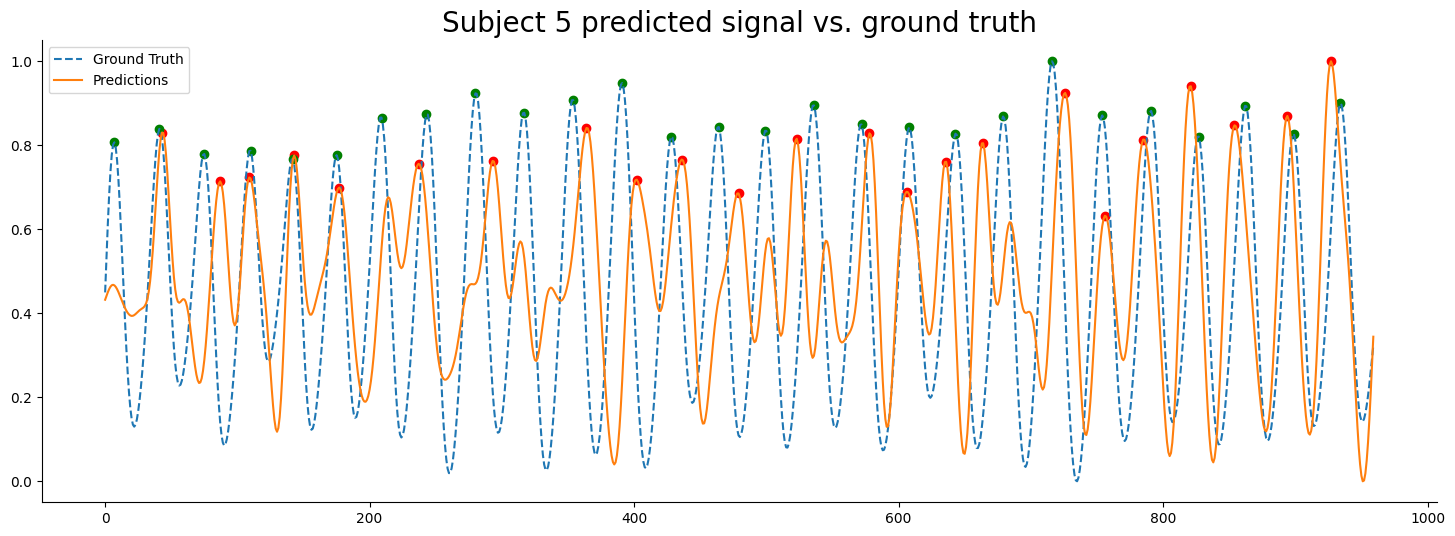

In [64]:
beg = 3000
end = beg + 960

res = []

for i in range(15):
    begg = beg + i * 960
    endd = begg + 960

model = mod

data = test_subject_truth.prepare_data_for_ml(8, 12)
x = xgb.DMatrix(data.drop(columns = ['bvp']).to_numpy())
y = data['bvp'].to_numpy()

def measure_code_block():
    t = datetime.today()
    targ = y[beg: end]
    pred = model.predict(x)
    pred = pred[beg: end]
    targ, pred = mod.process_signal(targ, pred, use_bandpass=True)
    print(f'Elapsed time: {datetime.today() - t}')
    return targ, pred

%memit targ, pred = measure_code_block()

pred_peaks, _ = mod.get_predicted_peaks(pred)
true_peaks, _ = mod.get_true_peaks(targ)

plt.plot(targ, linestyle = '--', label = 'Ground Truth')
plt.plot(pred, label = 'Predictions')
plt.legend()
plt.title(f'Subject {test_subject} predicted signal vs. ground truth', fontsize = 20)
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')

# Set the bottom and left spines to be the x and y axes, respectively
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')

Elapsed time: 0:00:00.043385
peak memory: 313.77 MiB, increment: 0.00 MiB
True HR: 44.70314318975553; Pred HR: 51.717171717171716


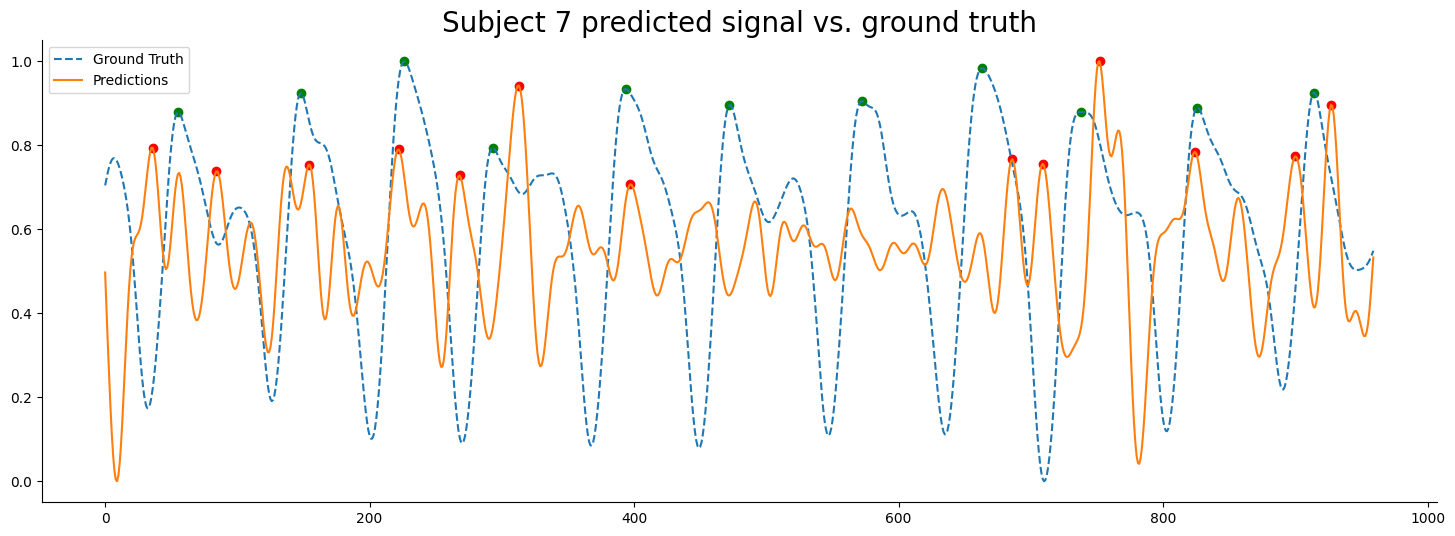

In [67]:
beg = 2000
end = beg + 960

res = []

for i in range(15):
    begg = beg + i * 960
    endd = begg + 960

model = mod

data = test_subject_truth.prepare_data_for_ml(8, 12)
x = xgb.DMatrix(data.drop(columns = ['bvp']).to_numpy())
y = data['bvp'].to_numpy()

def measure_code_block():
    t = datetime.today()
    targ = y[beg: end]
    pred = model.predict(x)
    pred = pred[beg: end]
    targ, pred = mod.process_signal(targ, pred, use_bandpass=True)
    print(f'Elapsed time: {datetime.today() - t}')
    return targ, pred

%memit targ, pred = measure_code_block()

pred_peaks, _ = mod.get_predicted_peaks(pred)
true_peaks, _ = mod.get_true_peaks(targ)

plt.plot(targ, linestyle = '--', label = 'Ground Truth')
plt.plot(pred, label = 'Predictions')
plt.legend()
plt.title(f'Subject {test_subject} predicted signal vs. ground truth', fontsize = 20)
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')

# Set the bottom and left spines to be the x and y axes, respectively
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')

Elapsed time: 0:00:00.031450
peak memory: 300.53 MiB, increment: 0.00 MiB
True HR: 57.8168130489335; Pred HR: 50.40572792362768


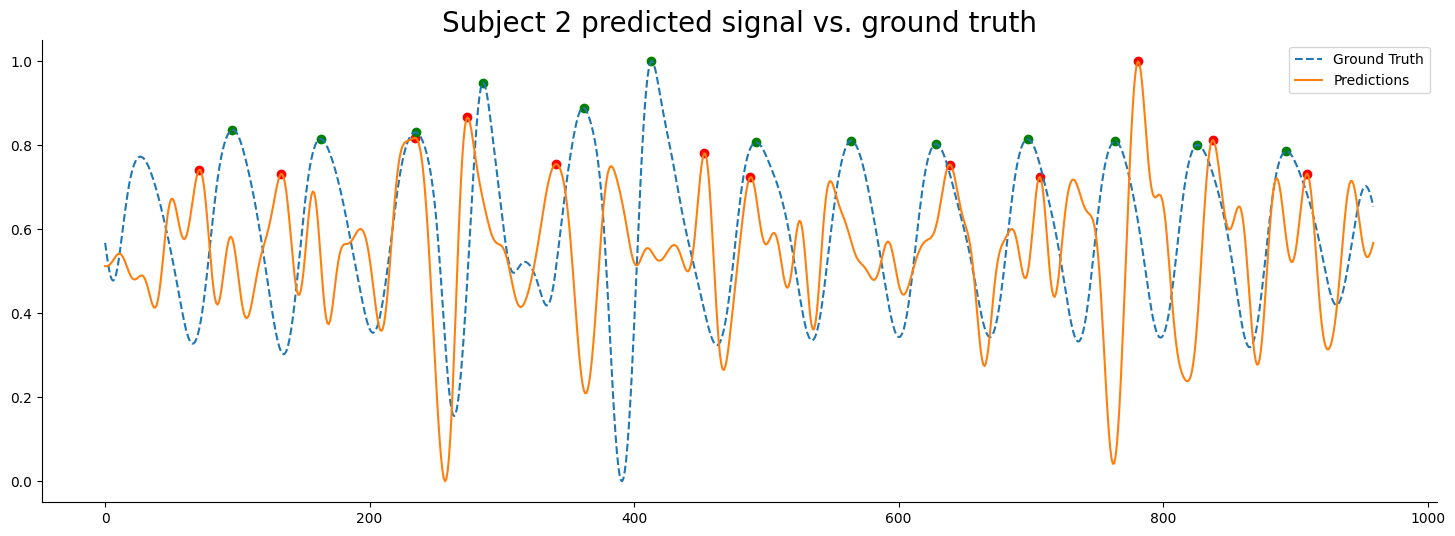

In [61]:
beg = 3000
end = beg + 960

res = []

for i in range(15):
    begg = beg + i * 960
    endd = begg + 960

model = mod

data = test_subject_truth.prepare_data_for_ml(8, 12)
x = xgb.DMatrix(data.drop(columns = ['bvp']).to_numpy())
y = data['bvp'].to_numpy()

def measure_code_block():
    t = datetime.today()
    targ = y[beg: end]
    pred = model.predict(x)
    pred = pred[beg: end]
    targ, pred = mod.process_signal(targ, pred, use_bandpass=True)
    print(f'Elapsed time: {datetime.today() - t}')
    return targ, pred

%memit targ, pred = measure_code_block()

pred_peaks, _ = mod.get_predicted_peaks(pred)
true_peaks, _ = mod.get_true_peaks(targ)

plt.plot(targ, linestyle = '--', label = 'Ground Truth')
plt.plot(pred, label = 'Predictions')
plt.legend()
plt.title(f'Subject {test_subject} predicted signal vs. ground truth', fontsize = 20)
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')

# Set the bottom and left spines to be the x and y axes, respectively
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')

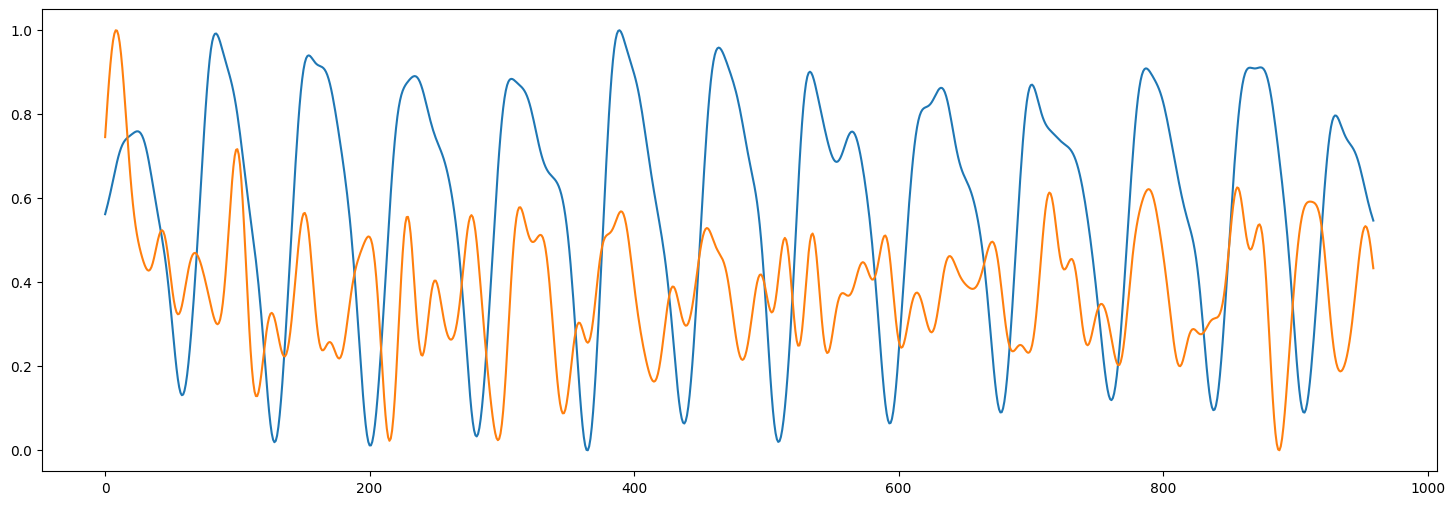

In [15]:
import scipy
def ppg_to_bvp(ppg_signal, sampling_rate, cutoff_frequency=0.1):
    """
    Convert a PPG (Photoplethysmogram) signal to a BVP (Blood Volume Pulse) signal using a highpass filter.

    Parameters:
    ppg_signal (array-like): Input PPG signal
    sampling_rate (float): Sampling rate of the PPG signal in Hz
    cutoff_frequency (float, optional): Cutoff frequency for the highpass filter in Hz (default: 0.1 Hz)

    Returns:
    bvp_signal (np.array): Output BVP signal
    """

    # Create a highpass Butterworth filter
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff_frequency = cutoff_frequency / nyquist_frequency
    b, a = scipy.signal.butter(N=1, Wn=normalized_cutoff_frequency, btype='high', analog=False)

    # Apply the highpass filter to the PPG signal
    bvp_signal = scipy.signal.lfilter(b, a, ppg_signal)

    return min_max_scale(bvp_signal)

pred = ppg_to_bvp(pred, 64)
plt.plot(targ)
plt.plot(pred)

In [ ]:
import scipy
def normalized_lomb_periodogram(time, ibis, frequency_range):
    """
    Calculate the normalized Lomb periodogram of detrended IBIs.

    Args:
    time (numpy array): The time values of the IBIs
    ibis (numpy array): The detrended IBIs
    frequency_range (tuple): A tuple with the minimum and maximum frequencies to consider (min_freq, max_freq)

    Returns:
    (numpy array, numpy array): The frequencies and corresponding Lomb periodogram values
    """

    # Calculate the Lomb periodogram
    angular_frequencies = np.linspace(frequency_range[0] * 2 * np.pi, frequency_range[1] * 2 * np.pi, len(time))
    periodogram = scipy.signal.lombscargle(time, ibis, angular_frequencies, normalize=True)

    # Convert angular frequencies to regular frequencies
    frequencies = angular_frequencies / (2 * np.pi)

    return frequencies, periodogram

def plot_normalized_lomb_periodogram(time, ibis, frequency_range):
    # Calculate the Lomb periodogram using the normalized_lomb_periodogram function
    frequencies, periodogram = normalized_lomb_periodogram(time, ibis, frequency_range)

    # Create a plot using matplotlib
    plt.figure(figsize=(10, 5))
    plt.plot(frequencies, periodogram)

    # Label the axes and add a title
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Normalized Lomb Periodogram of Detrended IBIs")

    # Display the plot
    plt.show()


true_time = np.cumsum(true_ibis)
pred_time = np.cumsum(pred_ibis)

plot_normalized_lomb_periodogram(true_time, true_ibis, (0.7, 4.0))
plot_normalized_lomb_periodogram(pred_time, pred_ibis, (0.7, 4.0))



In [ ]:
import numpy as np

def pearson_correlation(x, y):
    """
    Calculate the Pearson correlation coefficient between two 1D NumPy arrays.

    Args:
    x (numpy array): The first 1D NumPy array
    y (numpy array): The second 1D NumPy array

    Returns:
    float: The Pearson correlation coefficient
    """

    # Compute the correlation matrix using numpy.corrcoef
    corr_matrix = np.corrcoef(x, y)

    # Extract the correlation coefficient (off-diagonal element)
    correlation_coefficient = corr_matrix[0, 1]

    return correlation_coefficient

# Example usage:
# x = np.array([...])  # Your first 1D NumPy array
# y = np.array([...])  # Your second 1D NumPy array
# correlation = pearson_correlation(x, y)
print(pred.shape)
pearson_correlation(targ, pred)